In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import pandas as pd
from functional import seq
from tqdm.auto import tqdm

from utils import process_viztrace_json

In [3]:
df_mems = []
for file in tqdm(sorted(Path('benchmark_jsons').glob('*.json'))):
    try:
        df_mem, df_info = process_viztrace_json(file)
        df_mem[["toolkit", "index", "nb_traces", "n", "n_out", "headless"]] = (
            seq(file.name.split(".")[0].split("__"))
                .map(lambda x: x.split("=")[-1])
                .to_list()
        )
        df_mem[['index', 'nb_traces', 'n', 'n_out']] = df_mem[
            ['index', 'nb_traces', 'n', 'n_out']].astype(int)
        df_mem.loc[:df_info[df_info.name.str.contains('constructed image')].index[0],
        'phase'] = 'image construction'
        df_mem.loc[df_info[df_info.name.str.contains('constructed image')].index[0]:,
        'phase'] = 'rendering'
        df_mems.append(df_mem.reset_index())
    except Exception as e:
        print(file)
        print(e)

  0%|          | 0/1111 [00:00<?, ?it/s]

In [4]:
df_mem_tot = pd.concat(df_mems, ignore_index=True)
df_mem_tot['args.rss'] /= 1e6
df_mem_tot.rename(columns={'args.rss': 'memory (MB)'}, inplace=True)
df_mem_tot = pd.concat([df_mem_tot, pd.read_parquet('df_mem_tot.parquet', engine='fastparquet')], ignore_index=True)
df_mem_tot['n'] = df_mem_tot['n'].map(lambda x: f'{x:,}')
df_mem_tot['ts'] = df_mem_tot.ts.dt.total_seconds()
df_mem_tot.rename(columns={'ts': 'duration (s)'}, inplace=True)

In [5]:
df_mem_viz = (
    df_mem_tot.groupby(["toolkit", "index", "nb_traces", 'n'])[["duration (s)", "memory (MB)"]]
        .max()
        .reset_index()
        # .groupby(["toolkit", "nb_traces"])[["ts", "memory (MB)"]]
        # .apply(
        #     lambda x: pd.Series(
        #         data=x.mean().values.tolist() + (20 * x.std()).values.tolist(),
        #         index=("mean_" + x.columns).tolist() + ("std_" + x.columns).tolist(),
        #     )
        # )
        # .reset_index()
)
df_mem_viz_r = df_mem_viz[df_mem_viz['n'] != '500,000']

In [6]:
df_mem_viz

,toolkit,index,nb_traces,n,duration (s),memory (MB)
0,holoviews_LTTB,0,1,"1,000,000",1.919810,14.544896
1,holoviews_LTTB,0,1,"100,000",1.940826,3.792896
2,holoviews_LTTB,0,1,"20,000",1.961318,3.129344
3,holoviews_LTTB,0,1,"5,000,000",1.980874,61.906944
4,holoviews_LTTB,0,1,"500,000",1.959945,8.683520
...,...,...,...,...,...,...
3998,plotly_resampler,9,200,"1,000,000",4.419614,50.900992
3999,plotly_resampler,9,200,"100,000",3.415759,34.541568
4000,plotly_resampler,9,200,"20,000",3.377393,33.906688
4001,plotly_resampler,9,200,"5,000,000",8.974691,79.065088


In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_context('talk')

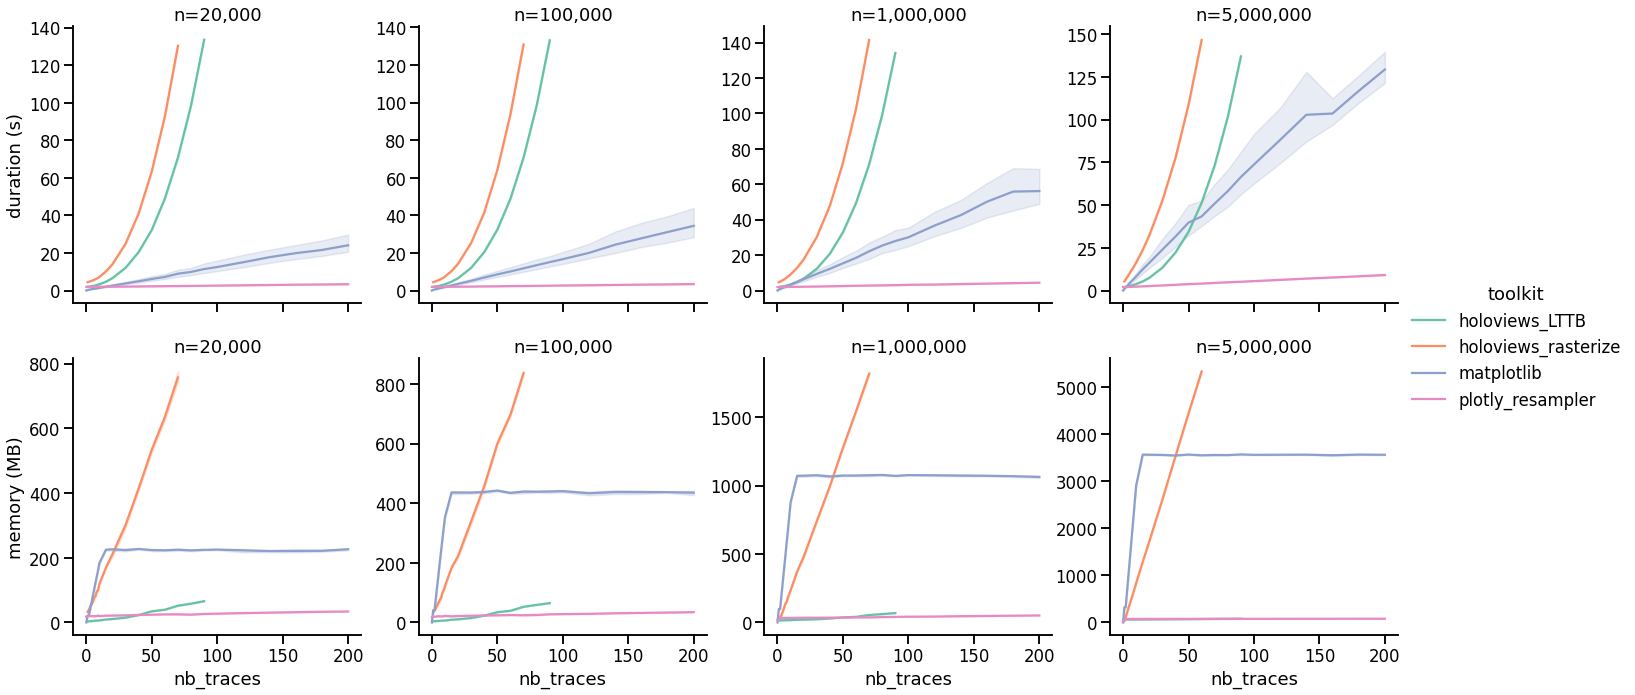

In [14]:
row_order = ['duration (s)', 'memory (MB)']
g = sns.relplot(
    data=df_mem_viz_r.melt(id_vars=['nb_traces', 'toolkit', 'index', 'n']),
    kind='line',
    hue='toolkit',
    x='nb_traces',
    y='value',
    row='variable',
    height=5,
    palette='Set2',
    col='n',
    col_order=['20,000', '100,000', '1,000,000', '5,000,000'],
    row_order=row_order,
    facet_kws={'sharey': False} #'sharex': 'row'}
)
g.set_titles("{col_var}={col_name}")
for row_axs, row_name in zip(g.axes, row_order):
    row_axs[0].set_ylabel(row_name)
plt.subplots_adjust(wspace=0.2, hspace=0.2)

In [15]:
g.savefig('../reports/benchmark_figure.png', dpi=200)

In [40]:
# g = sns.relplot(
#     data=df_mem_viz_r.rename(columns={'ts': 'duration (s)'}),
#     kind='line',
#     hue='toolkit',
#     x='nb_traces',
#     y='duration (s)',
#     height=9,
#     palette='Set2',
#     col='n'
# )

In [ ]:
# df_mem_viz = (
#     df_mem_tot.groupby(["toolkit", "index", "nb_traces"])[["ts", "memory (MB)"]]
#     .max()
#     .reset_index()
#     .groupby(["toolkit", "nb_traces"])[["ts", "memory (MB)"]]
#     .apply(
#         lambda x: pd.Series(
#             data=x.mean().values.tolist() + (20 * x.std()).values.tolist(),
#             index=("mean_" + x.columns).tolist() + ("std_" + x.columns).tolist(),
#         )
#     )
#     .reset_index()
# )